# JWST Pipeline Validation Testing notebook: flat_field step with MIRI Imaging

Instruments Affected: NIRCam, NIRSpec, NIRISS, MIRI, FGS

## Introduction 

This test is designed to test the flat_field step in the calwebb_image2 pipeline. This step retrieves the correct flat field reference file and divides the data by the reference file. The SCI extension of the reference file is divided into the SCI array of the science image. The DQ plane of the reference file is combined with the DQ plane of the science file. 

Error calculation: 
The VAR_POISSON and VAR_RNOISE variance arrays of the science exposure are divided by the square of the flat-field value for each pixel. A flat-field variance array, VAR_FLAT, is created from the science exposure and flat-field reference file data using the following formula:

var_flat = SCI array ^ 2 / flat SCI array ^ 2 * flat err array ^2

The total ERR array in the science exposure is updated as the square root of the quadratic sum of VAR_POISSON, VAR_RNOISE, and VAR_FLAT.

Description of the steps applied: 

- If the science data have been taken using a subarray and the flat-field reference file is a full-frame image, extract the corresponding subarray region from the flat-field data.

- Find pixels that have a value of NaN or zero in the FLAT reference file SCI array and set their DQ values to “NO_FLAT_FIELD.”

- Reset the values of pixels in the flat that have DQ=”NO_FLAT_FIELD” to 1.0, so that they have no effect when applied to the science data.

- Apply the flat by dividing it into the science exposure SCI array.

- Propagate the FLAT reference file DQ values into the science exposure DQ array using a bitwise OR operation.

#### Documentation
For more information on the pipeline step visit the links below. 

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst


## Test Description

This notebook processes an image through calwebb_image2 (calwebb_detector1 is optional) and examines the output of the flat_field step. The steps are as follow:

1) Retrieve data.

2) Run output of calwebb_detector1 through the flat_field step in calwebb_image2. Visualize the sci arrays of the data before and after the flat_field step is applied. 

3) Get flat field reference file. Look at the sci array of the flat_field reference file.

4) Compare the flat field reference file with the rate/cal image ratio and check that they are the same.

5) Look at the ERR arrays of the science data before and after the step is run, and compare to the flat_field reference file ERR array to be sure there is no unexpected pattern seen. Check that a new extension (var_flat) has been added to the output data.

6) Check that the DQ flags were applied as expected. 

## Data used 

The data used in this test is a simulated MIRI image created using MIRISim. The documentation for MIRISim can be found here: https://wiki.miricle.org/bin/view/Public/MIRISim_Public


In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpt8xhx244'>


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


### Set up import statements

Software imports:

- astropy allows various data formats to be read in and written out as well as visualization tools for plotting
- numpy provides the framework to work with arrays and standard calculations
- matplotlib is a set of plotting software
- jwst is all of the jwst calibration pipeline software being tested
- download_file, move and get_bigdata are used in downloading the data to be used.

In [3]:
from astropy.io import fits, ascii
from astropy.utils.data import download_file
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from shutil import move

import jwst
from jwst.pipeline import Detector1Pipeline, Image2Pipeline
from jwst.flatfield import FlatFieldStep
from jwst.datamodels import RampModel, ImageModel, dqflags
from jwst.pipeline import calwebb_image2

from ci_watson.artifactory_helpers import get_bigdata
import crds
import os

### Print pipeline version number

In [4]:
jwst.__version__ 

'1.4.3'

### Read in data from artifactory (or Box)

In [5]:
#input_file = get_bigdata('jwst_validation_notebooks',
#                     'validation_data',
#                     'flat_field',
#                     'flat_field_miri_test', 
#                     'car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits')

In [6]:
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)
        #print(file_name)


file_list=[('https://stsci.box.com/shared/static/kzef4nvyzzpfy4x4o108x344qg5epaf0.fits',
            'car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits')]

get_box_files(file_list)
filename = file_list[0][1]
print(filename)

car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits


In [7]:
# Read in data from Box
 
#file_url = 'https://stsci.box.com/shared/static/kzef4nvyzzpfy4x4o108x344qg5epaf0.fits'
#filename = 'car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits' 

#input_file = download_file(file_url)
#print(input_file)
 
#ext = os.path.splitext(file_url)[1]
#new_input_file = input_file + ext
 
#move(input_file, new_input_file)
    

### Read in input image as JWST data model

In [8]:
#im = ImageModel(new_input_file)  
#im.save(filename)

In [9]:
im = ImageModel(filename)

In [10]:
im.info() # Make sure image was read into the model correctly and has the expected extensions

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): Space Telescope Science Institute
│ ├─homepage (str): http://github.com/spacetelescope/asdf
│ ├─name (str): asdf
│ └─version (str): 2.7.3
├─history (dict)
│ └─extensions (list) ...
├─_fits_hash (str): 993cd5863a595d09a40aec3c631adf4350abcb491df37d32fee6dcfb6b40dc9f
├─data (NDArrayType): shape=(1024, 1032), dtype=float32
├─dq (NDArrayType): shape=(1024, 1032), dtype=uint32
├─err (NDArrayType): shape=(1024, 1032), dtype=float32
├─meta (dict)
│ ├─bunit_data (str): DN/s
│ ├─bunit_err (str): DN/s
│ ├─cal_step (dict) ...
│ ├─calibration_software_revision (str): RELEASE
│ ├─calibration_software_version (str): 1.1.0
│ ├─coordinates (dict) ...
│ ├─date (str): 2021-05-05T14:35:30.288
│ └─14 not shown
├─var_poisson (NDArrayType): shape=(1024, 1032), dtype=float32
└─var_rnoise (NDArrayType): shape=(1024, 1032), dtype=float32
Some nodes not shown.


### Display the rate (slope) file that is output of calwebb_detector1

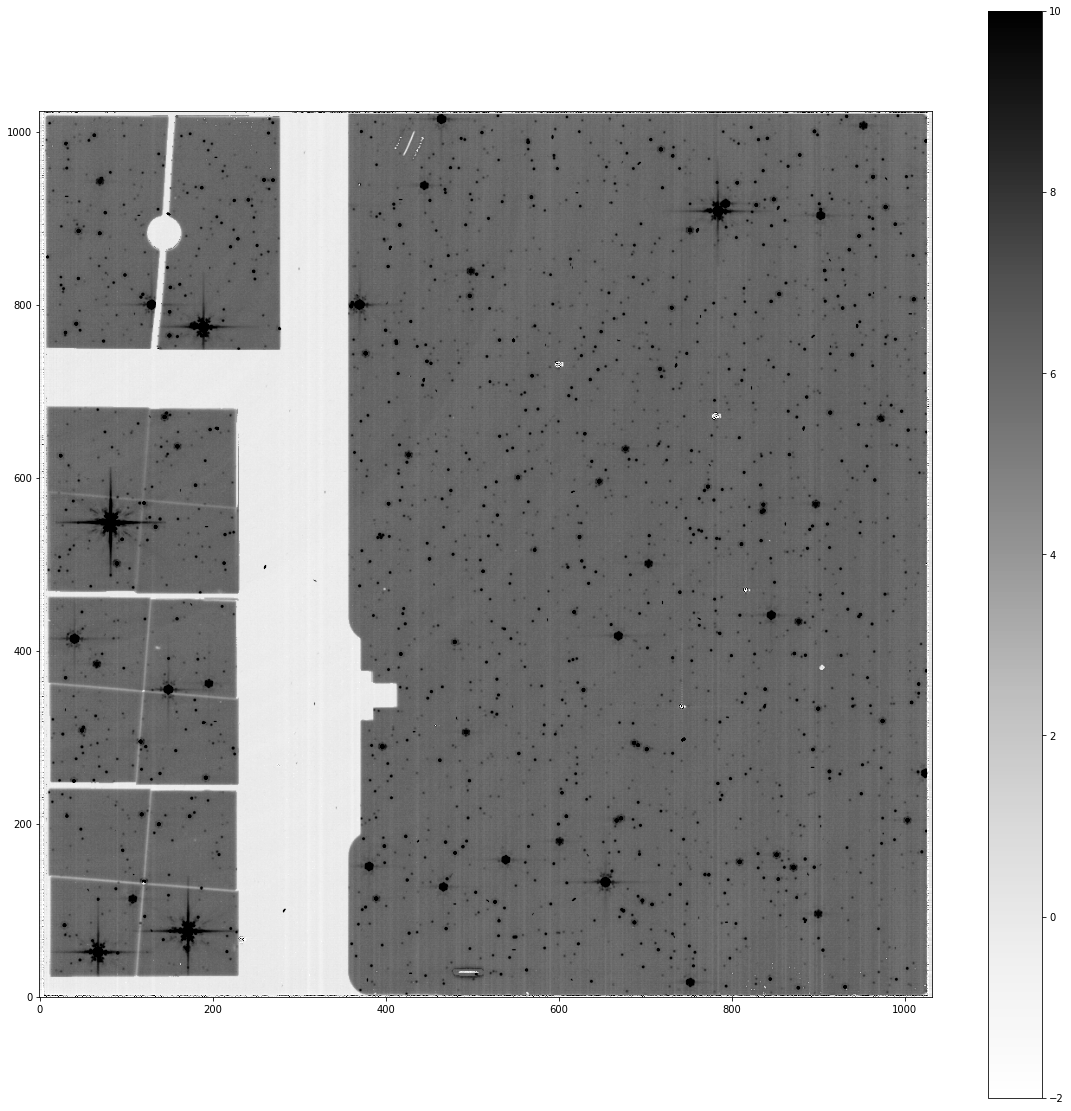

In [11]:
plt.figure(figsize=(20,20))
plt.imshow(im.data, cmap='Greys', origin='lower', vmin=-2,vmax=10)
plt.colorbar()
plt.show()

### Run output of calwebb_detector1 through the flat field step

In [12]:
im2 = FlatFieldStep()
im2.save_results = True
flatfile = im2.run(im)

2022-03-23 20:54:48,877 - stpipe.FlatFieldStep - INFO - FlatFieldStep instance created.


2022-03-23 20:54:49,027 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep running with args (<ImageModel(1024, 1032) from car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits>,).


2022-03-23 20:54:49,029 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-03-23 20:54:49,838 - stpipe.FlatFieldStep - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-23 20:54:49,839 - stpipe.FlatFieldStep - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-23 20:54:49,840 - stpipe.FlatFieldStep - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-23 20:54:49,850 - stpipe.FlatFieldStep - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-03-23 20:54:50,105 - stpipe.FlatFieldStep - INFO - Saved model in car007_seq1_MIRIMAGE_F770Wexp1_b771_flatfieldstep.fits


2022-03-23 20:54:50,107 - stpipe.FlatFieldStep - INFO - Step FlatFieldStep done


In [13]:
# Read output of calwebb_image2 into a data model

im_cal = ImageModel(flatfile)
print(im_cal.meta.filename)

car007_seq1_MIRIMAGE_F770Wexp1_b771_flatfieldstep.fits


### Display the calibrated data that is output of calwebb_image2

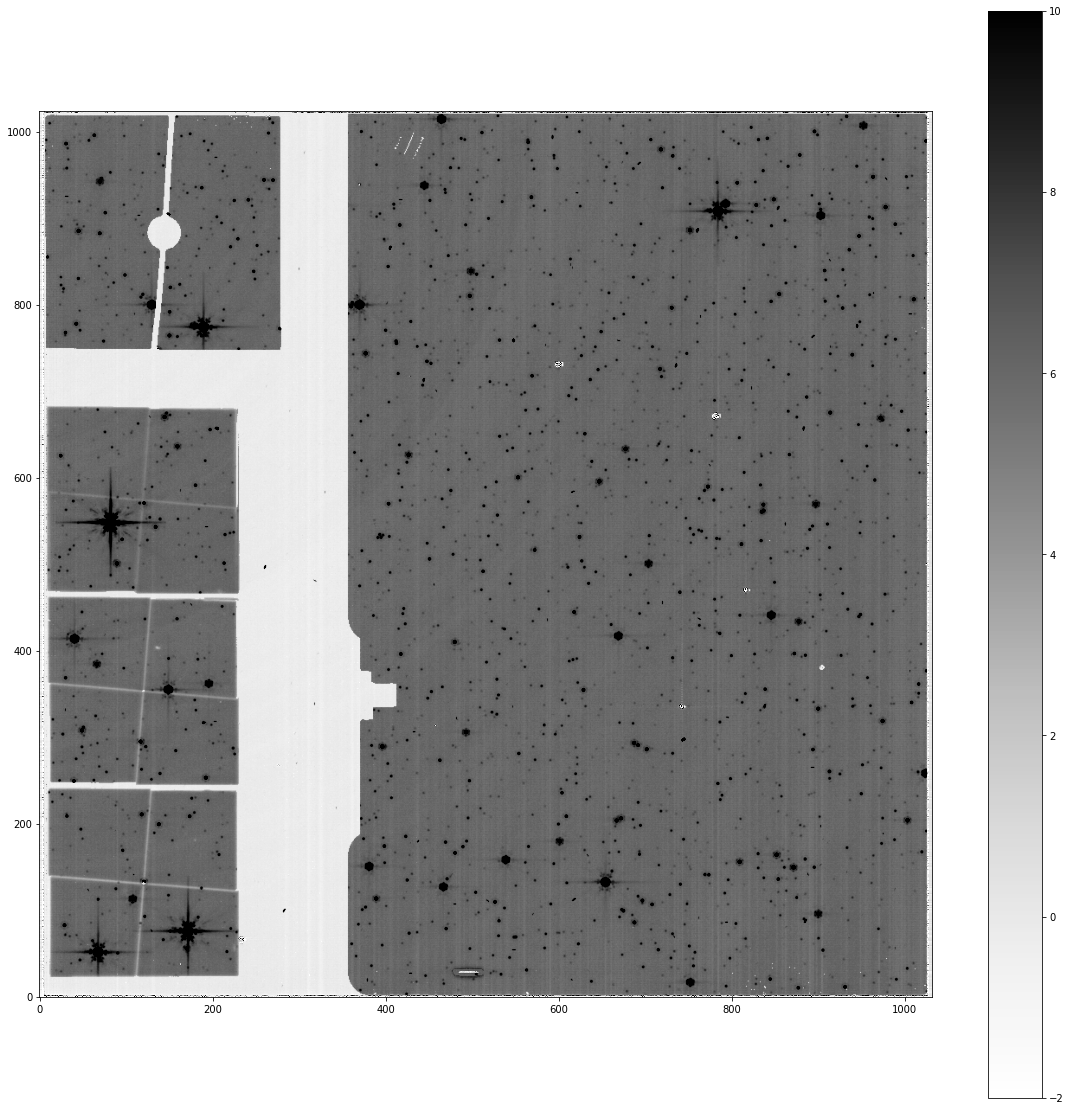

In [14]:
plt.figure(figsize=(20,20))
plt.imshow(im_cal.data, cmap='Greys', origin='lower', vmin=-2,vmax=10)#, norm=norm)
plt.colorbar()
plt.show()

### Calculate the rate/cal image ratio

In [15]:
ratio_im = im.data / im_cal.data

print('Minimum and maximum values in the ratio image are:', np.nanmin(ratio_im), 'and', np.nanmax(ratio_im))

Minimum and maximum values in the ratio image are: 0.29343417 and 1.1597172


### Display ratio image

The ratio of the images calculated above should be comparable to the flat field reference file science extension.

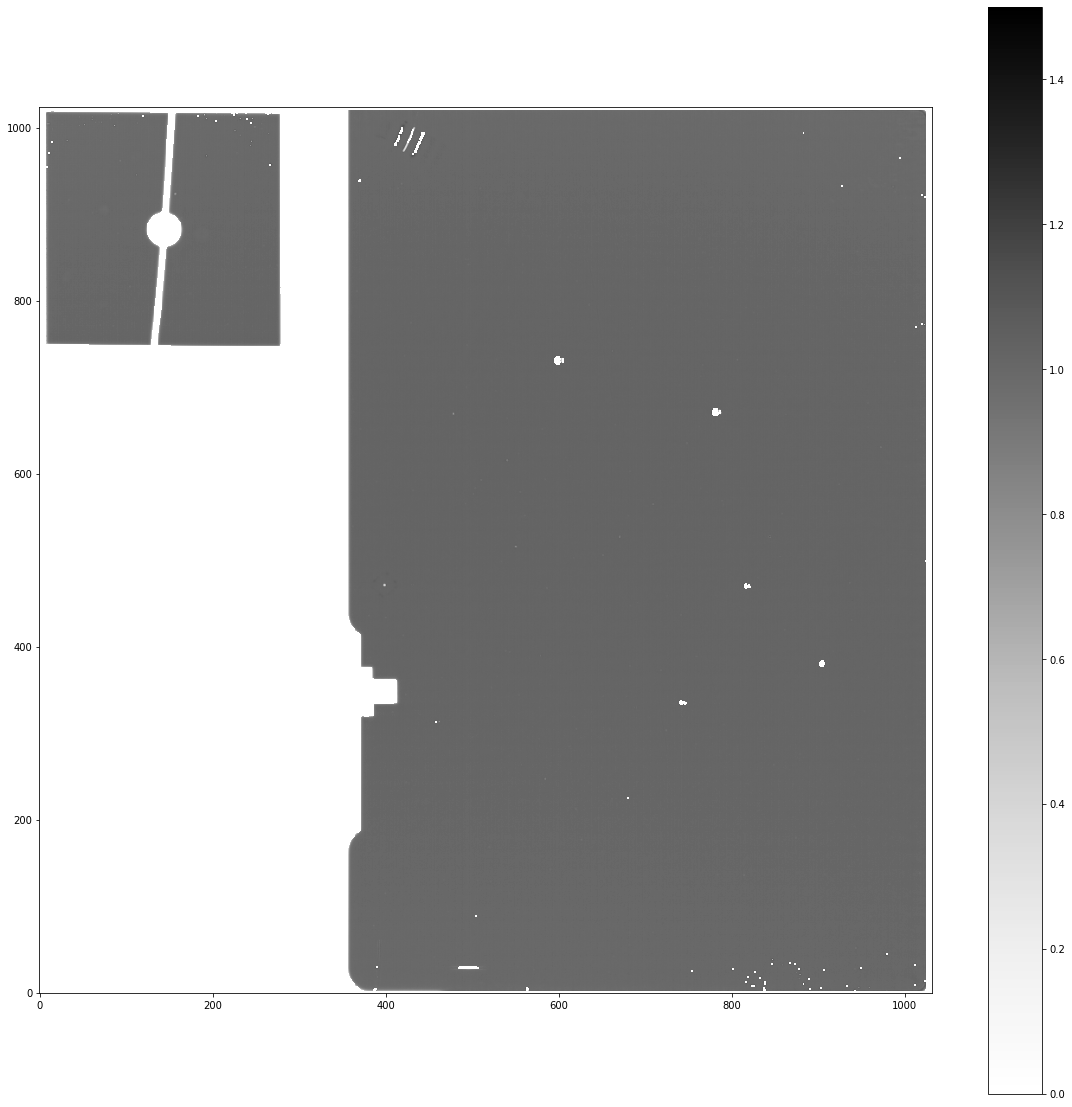

In [16]:
plt.figure(figsize=(20,20))

# mask out DO_NOT_USE values of 1
masked_ratio = np.ma.masked_where((im_cal.dq & dqflags.pixel['DO_NOT_USE'] > 0), ratio_im)

cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white') # color to mark all DO_NOT_USE pixels

plt.imshow(masked_ratio, cmap=cmap, origin='lower', vmin=0,vmax=1.5)
plt.colorbar()
plt.show()

### Get flat_field reference file

In [17]:
flatreffile = im_cal.meta.ref_file.flat.name
print('Flat reference file', flatreffile)
# find location of file
basename = crds.core.config.pop_crds_uri(flatreffile)
path = crds.locate_file(basename, "jwst")

# open reference file
flat_im = ImageModel(path)
print(flat_im.meta.filename)

print('Minimum and maximum values in the ratio image are:', np.nanmin(flat_im.data), 'and', np.nanmax(flat_im.data))

Flat reference file crds://jwst_miri_flat_0729.fits
jwst_miri_flat_0729.fits
Minimum and maximum values in the ratio image are: 0.29343417 and 1.1597172


### Display flat field reference file data

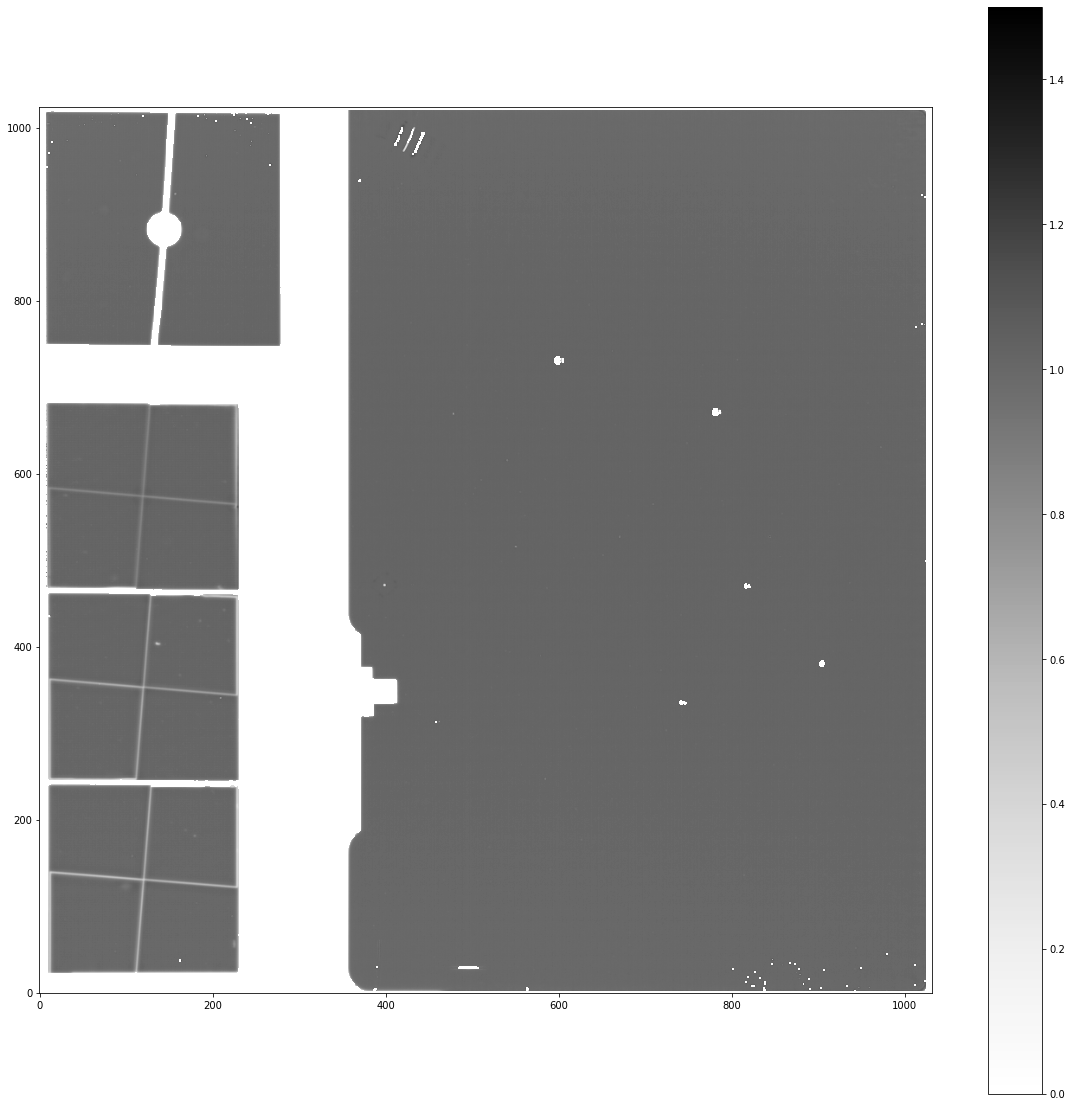

In [18]:
plt.figure(figsize=(20,20))
plt.imshow(flat_im.data, cmap='Greys', origin='lower', vmin=0,vmax=1.5)
plt.colorbar()
plt.show()

### Compare flat field reference file with the rate/cal image ratio and check that they are equal

Since the step sets any flat field values to 1 where the DQ array lists the pixel as DO_NOT_USE, only a masked version of the images should be compared to the flat. Find regions where dq values are not marked as DO_NOT_USE and compare the good regions.

In [19]:
# Do a check on any specific pixel in the imager. The rate file divided by the flat file should equal the value 
# in the flat_fielded output file.

xval = 600
yval = 600

print('Rate image pixel value', im.data[yval, xval])
print('Cal image pixel value', im_cal.data[yval, xval])
print('Flat pixel value', flat_im.data[yval, xval])
print('DQ value for flat file:', flat_im.dq[yval, xval])

div_val = im.data[yval, xval] / flat_im.data[yval, xval]
print('The rate file pixel divided by the flat file pixel is: ', div_val)

try:
    assert im_cal.data[yval,xval] == im.data[yval, xval] / flat_im.data[yval, xval]
except:
    print('Cal pixel does not equal rate divided by flat. There is a problem here.')

Rate image pixel value 6.3175173
Cal image pixel value 6.2235885
Flat pixel value 1.0150924
DQ value for flat file: 0
The rate file pixel divided by the flat file pixel is:  6.2235885


In [20]:
# mask out bad pixels, i.e. pixels marked as DO_NOT_USE in the reference file dq array

badpixels = np.where(flat_im.dq & dqflags.pixel['DO_NOT_USE'] > 0)

# Set bad pixels in images to nan so they are not part of calculations
good_im = im.data
good_im[badpixels] = np.nan

good_cal = im_cal.data
good_cal[badpixels] = np.nan

good_flat = flat_im.data
good_flat[badpixels] = np.nan

# Get the ratio of the masked images, and then divide by the masked flat image
test_ratio = good_im / good_cal

check_flat = test_ratio / good_flat

print('Minimum and maximum values in the ratio image are:', np.nanmin(test_ratio), 'and', np.nanmax(test_ratio))

Minimum and maximum values in the ratio image are: 0.29343417 and 1.1597172


### View the ratio image divided by the flat field ((rate / flat_fielded image) / flat field reference file)

The values of this image should be around 1.0. The flat fielded science image results from dividing the rate image by the flat field reference file image. So the ratio of the rate image divided by the flat_fielded image should equal the flat field reference file, meaning that ratio should equal 1.0.

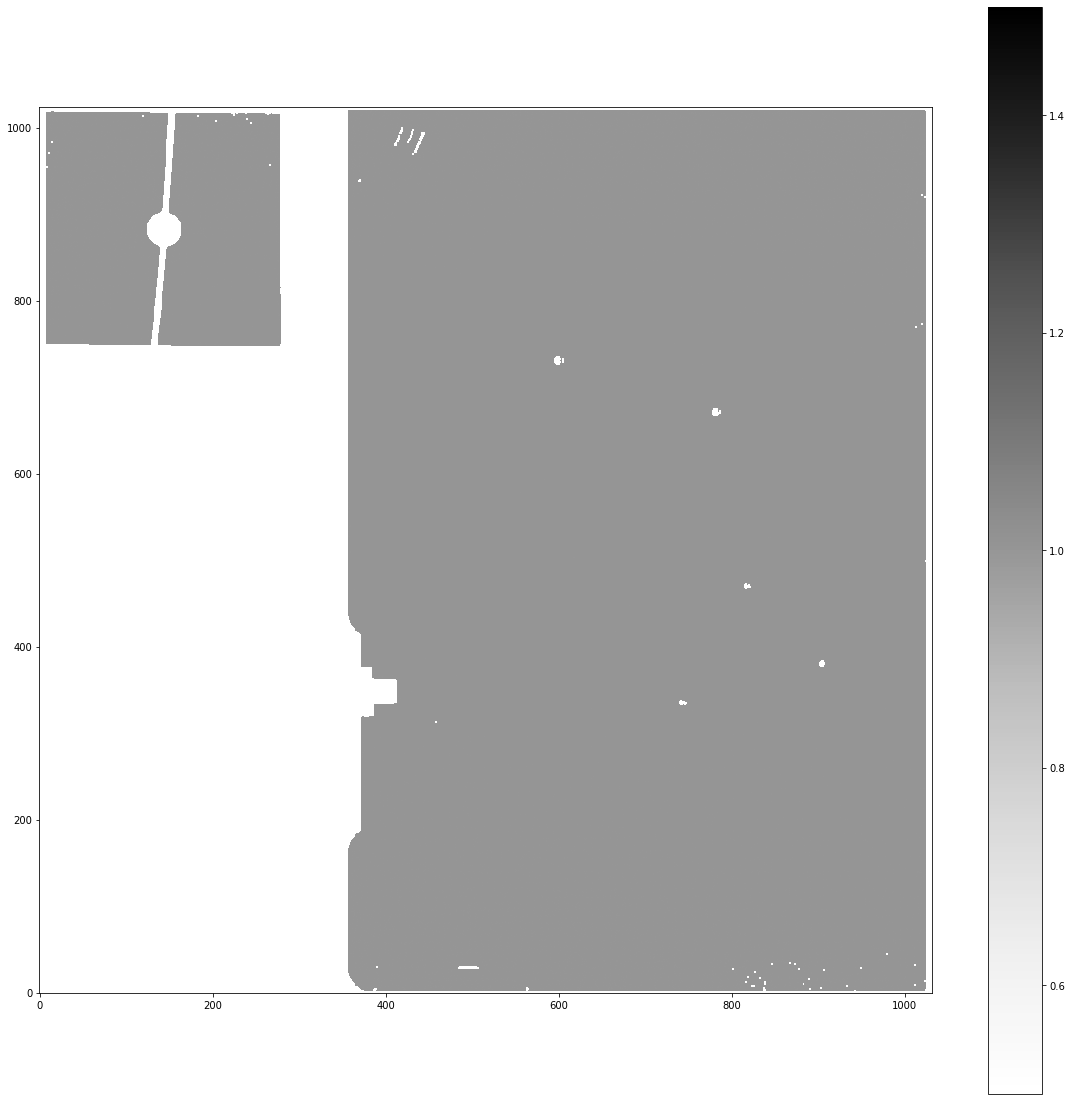

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(check_flat, cmap='Greys', origin='lower', vmin=0.5,vmax=1.5)
plt.colorbar()
plt.show()

### Check that min and max values of ratio image divided by the flat are 1.0

In [22]:
print('**************** Passing criteria check: Be sure that both of these values are near 1.0 *******')
print('Minimum and maximum values in the check_flat image are:', np.nanmin(check_flat), 'and', np.nanmax(check_flat))

try: 
    np.testing.assert_allclose(np.nanmin(check_flat), 1.0, rtol = 0.05)
except AssertionError: 
    print("AssertionError: The minimum value is not within 5% of 1.0")

try: 
    np.testing.assert_allclose(np.nanmax(check_flat), 1.0, rtol = 0.05)
except AssertionError: 
    print("AssertionError: The maximum value is not within 5% of 1.0")


**************** Passing criteria check: Be sure that both of these values are near 1.0 *******
Minimum and maximum values in the check_flat image are: 0.9999999 and 1.0000001


## Check ERR arrays
There should be a new ERR array (var_flat) attached. 


### Check that var_flat extension was added to data after flat field step was run

In [23]:
# Look at extensions of the rate file 
uncal_filename = str(im.meta.filename)
hdu = fits.open(uncal_filename)
hdu.info()
hdu.close()

Filename: car007_seq1_MIRIMAGE_F770Wexp1_b771_rate.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     128   ()      
  1  SCI           1 ImageHDU        45   (1032, 1024)   float32   
  2  ERR           1 ImageHDU        10   (1032, 1024)   float32   
  3  DQ            1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (1032, 1024)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (1032, 1024)   float32   
  6  ASDF          1 BinTableHDU     11   1R x 1C   [3590B]   


In [24]:
# Look at the extensions of cal file and check that a new extension 'var_flat' was added 
filename = str(im_cal.meta.filename)
hdu = fits.open(filename)
hdu.info()
hdu.close()

try:
    assert(im_cal.var_flat.shape == im_cal.data.shape)
except AssertionError:
    print('AssertionError: var_flat array is not the same shape as the data array')

Filename: car007_seq1_MIRIMAGE_F770Wexp1_b771_flatfieldstep.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     145   ()      
  1  SCI           1 ImageHDU        45   (1032, 1024)   float32   
  2  ERR           1 ImageHDU        10   (1032, 1024)   float32   
  3  DQ            1 ImageHDU        11   (1032, 1024)   int32 (rescales to uint32)   
  4  VAR_POISSON    1 ImageHDU         9   (1032, 1024)   float32   
  5  VAR_RNOISE    1 ImageHDU         9   (1032, 1024)   float32   
  6  VAR_FLAT      1 ImageHDU         9   (1032, 1024)   float32   
  7  ASDF          1 BinTableHDU     11   1R x 1C   [3841B]   


### Look at error arrays before and after flat field step to see if there are any unexplained changes

Min val:  0.11365883    Max val:  1414.915


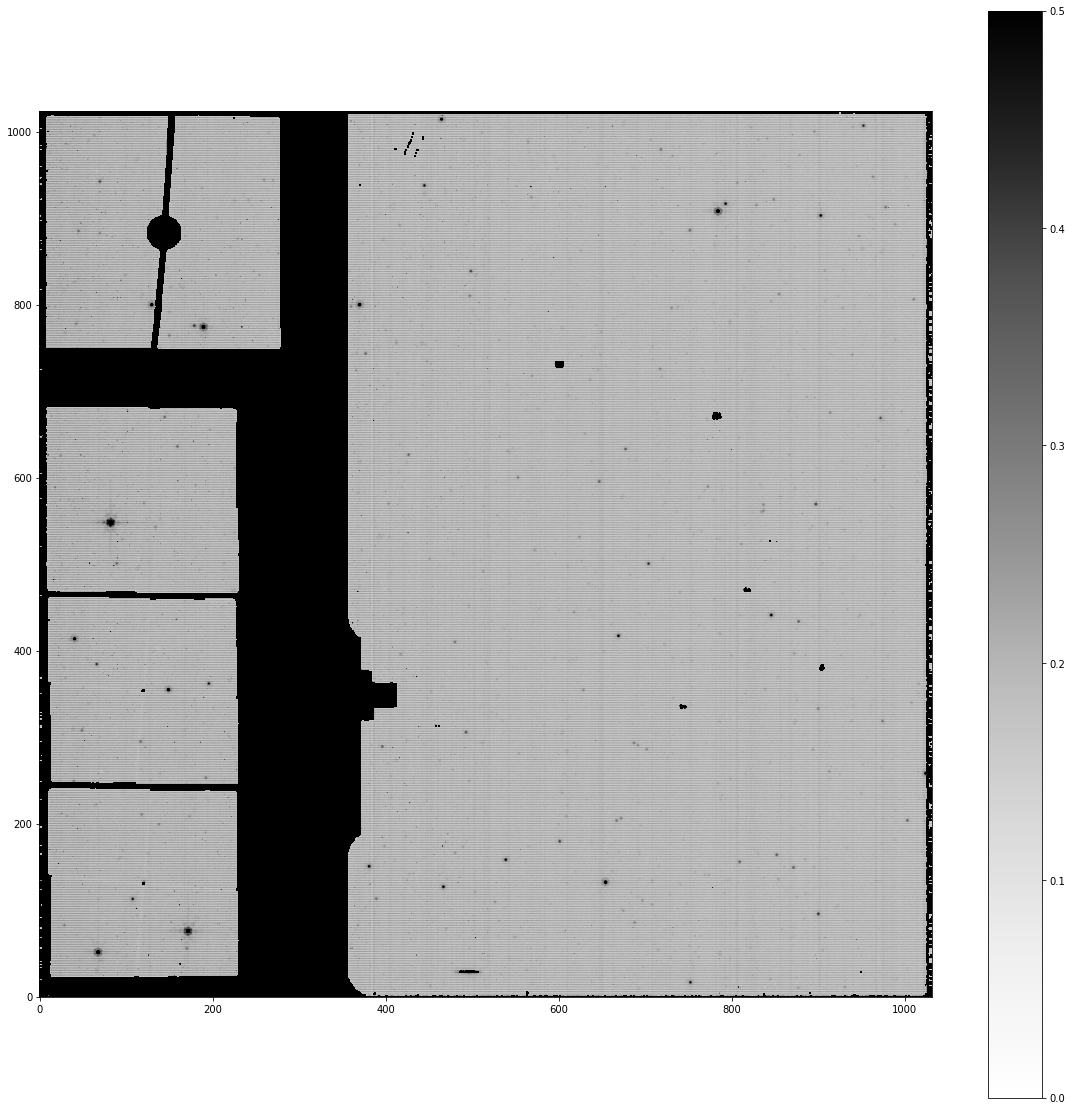

In [25]:
# ERR array of rate image

print('Min val: ', np.nanmin(im.err), '   Max val: ', np.nanmax(im.err))
plt.figure(figsize=(20,20))
plt.imshow(im.err, cmap='Greys', origin='lower', vmin=0,vmax=.5)
plt.colorbar()
plt.show()

Min val:  0.11002477    Max val:  inf


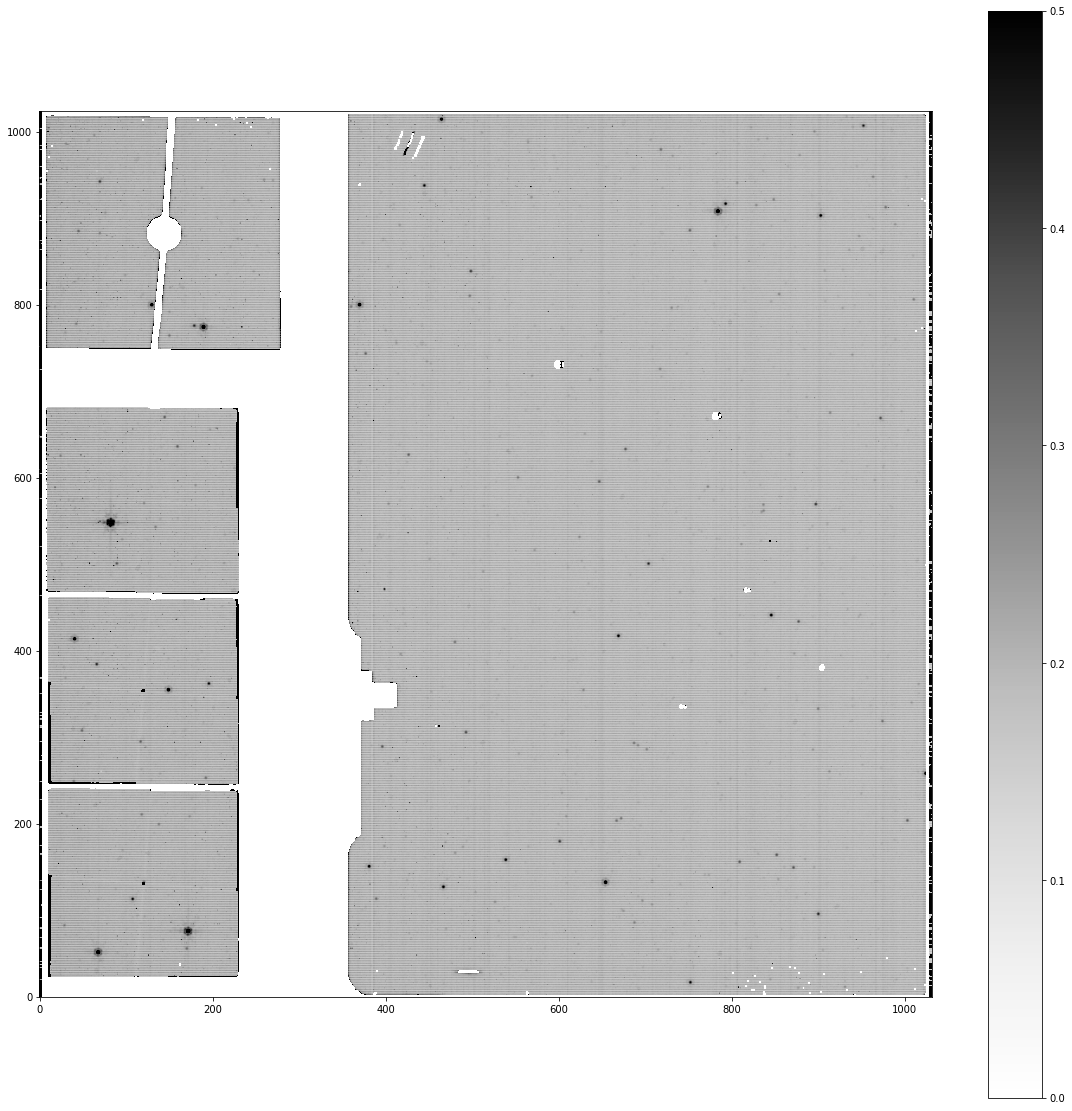

In [26]:
# ERR array of flat_fielded image

print('Min val: ', np.nanmin(im_cal.err), '   Max val: ', np.nanmax(im_cal.err))
plt.figure(figsize=(20,20))
plt.imshow(im_cal.err, cmap='Greys', origin='lower', vmin=0,vmax=.5)
plt.colorbar()
plt.show()

Min val:  0.11365883    Max val:  1414.915


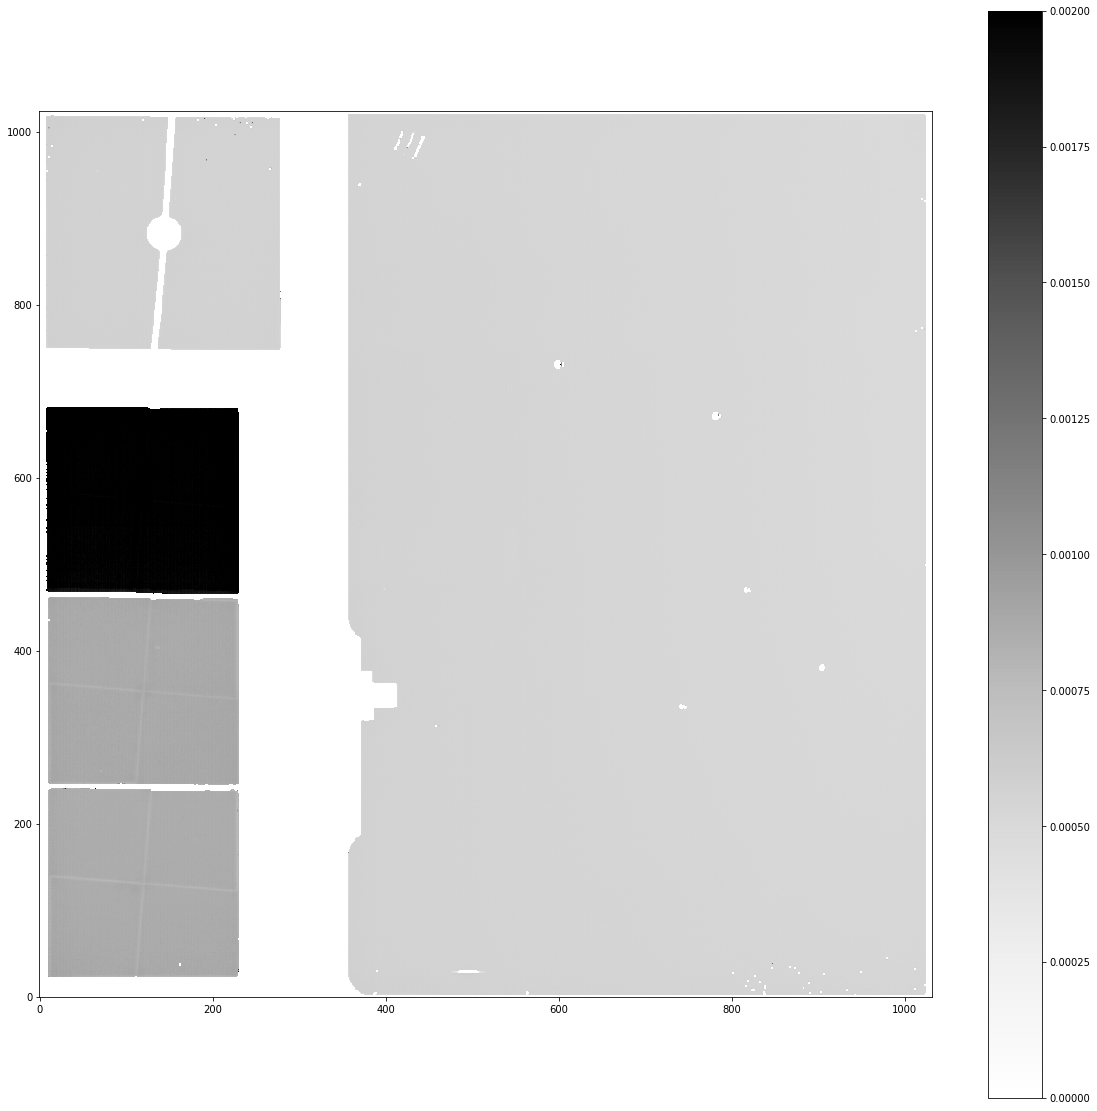

In [27]:
# ERR array of flat reference file image

print('Min val: ', np.nanmin(im.err), '   Max val: ', np.nanmax(im.err))
plt.figure(figsize=(20,20))
plt.imshow(flat_im.err, cmap='Greys', origin='lower', vmin=0,vmax=.002)
plt.colorbar()
plt.show()

### Check DQ flagging 
Any pixel flagged as NON_SCIENCE should also be flagged as DO_NOT_USE. Check if this is in place in both the input reference file and for the output science file of the calwebb_image2 pipeline. If there are no assert errors, the test below passes.

In [28]:
# Check if the output cal file is flagged properly

# Test that all pixels flagged with NON_SCIENCE are also flagged as DO_NOT_USE
nonsciencearray = (im_cal.dq & dqflags.pixel['NON_SCIENCE'] > 0)
badarray = (im_cal.dq & dqflags.pixel['DO_NOT_USE'] > 0)

try:
    assert nonsciencearray.all() == badarray.all()
except AssertionError:
    print('AssertionError: The NON_SCIENCE pixels are not equal to the DO_NOT_USE pixels in the flat_fielded file.')

# Test if the input reference file had the flags all set the same way

nonsciencearray = (flat_im.dq & dqflags.pixel['NON_SCIENCE'] > 0)
badarray = (flat_im.dq & dqflags.pixel['DO_NOT_USE'] > 0)

try:
    assert nonsciencearray.all() == badarray.all()
except AssertionError:
    print('AssertionError: The NON_SCIENCE pixels are not equal to the DO_NOT_USE pixels in the input file.')
   

In [29]:
# Look at DQ planes of rate and cal files and make sure flat field reference file was added to the rate file.

rate_dq = im.dq
cal_dq = im_cal.dq
flat_dq = flat_im.dq

try:
    assert cal_dq.all() == rate_dq.all() & flat_dq.all()
except AssertionError:
    print('AssertionError: The dq plane of the reference file was not added to the input dq plane properly.')
    

### Look at the dq planes to see how they change.

The dq planes shown below show the rate file before the flat field step, the reference file dq plane, and the dq plane after the flat field step is applied.

The regions marked with white have been set as 'DO_NOT_USE' in the dq plane. The images below should show that the 4QPM regions are marked as DO_NOT_USE by the flat field step. The rate image dq plane does not remove the 4QPM, but the flat field dq plane and the cal dq plane should both have the 4QPM regions marked as DO_NOT_USE.

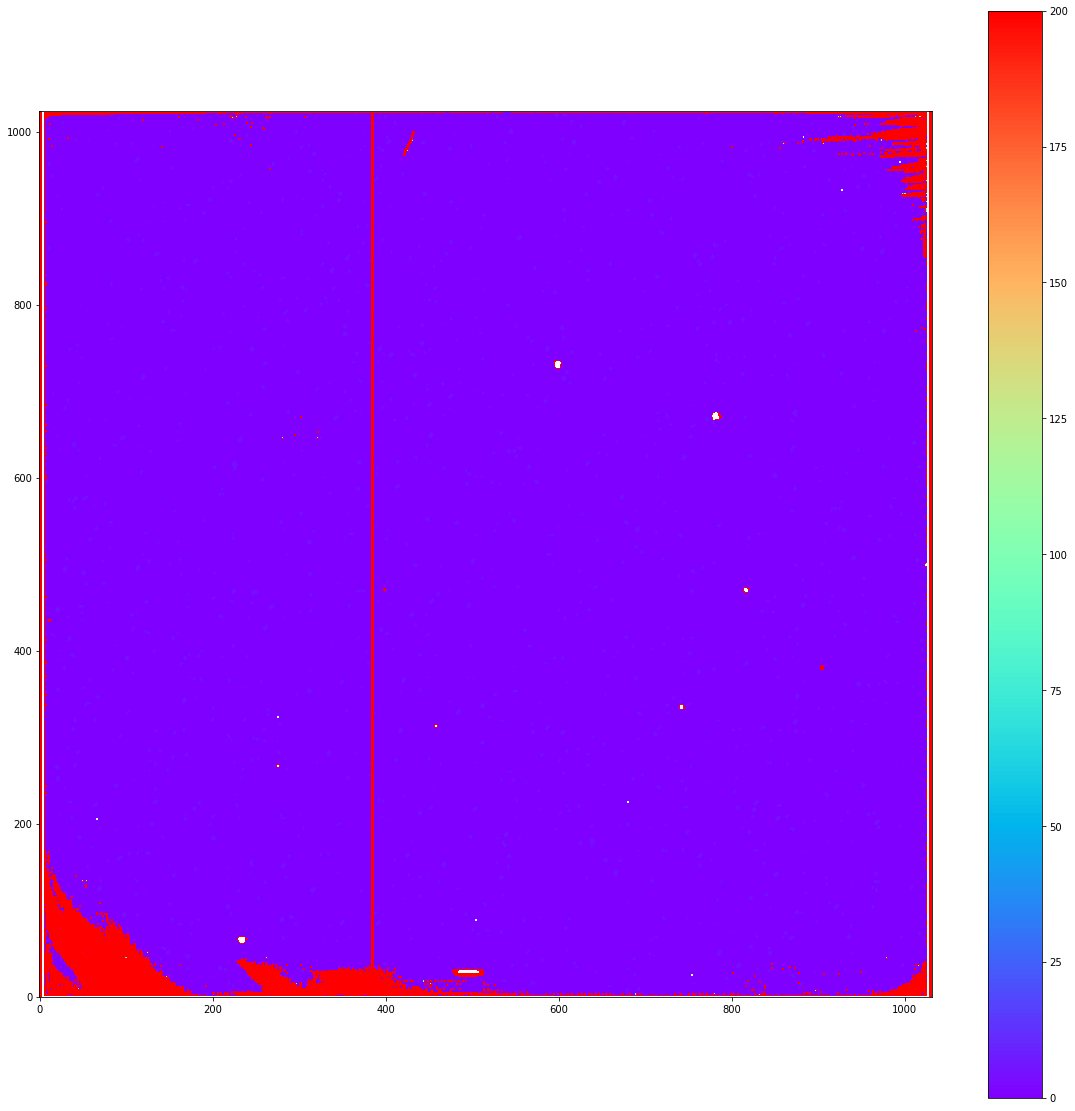

In [30]:
# Look at the dq plane of the rate image

plt.figure(figsize=(20,20))

# call out DO_NOT_USE values of 1
masked_array = np.ma.masked_where((rate_dq & dqflags.pixel['DO_NOT_USE'] > 0), rate_dq)

cmap = matplotlib.cm.get_cmap("rainbow").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

plt.imshow(masked_array, cmap=cmap, origin='lower', vmin=0,vmax=200)
plt.colorbar()
plt.show()

### Take a look at the dq plane of the flat field reference file.

The dq definitions in the flat field file are as follows (from the dq_def extention)

        Value    DQ Name
            1  DO_NOT_USE
            2  NON_SCIENCE
            4  UNRELIABLE_FLAT
            8  CDP_PARTIAL_DATA
           16  CDP_LOW_QUAL
           32  CDP_UNRELIABLE_ERROR
           64  NO_FLAT_FIELD
          128  DIFF_PATTERN
          
If the pixel has an odd numbered value, it has been combined with the value 'DO_NOT_USE', and is not applied in the division of the science data by the flat. These 'bad' pixels are flagged in the following image by being shown in white. The purple pixels have values of zero, which indicate they are good science pixels.          

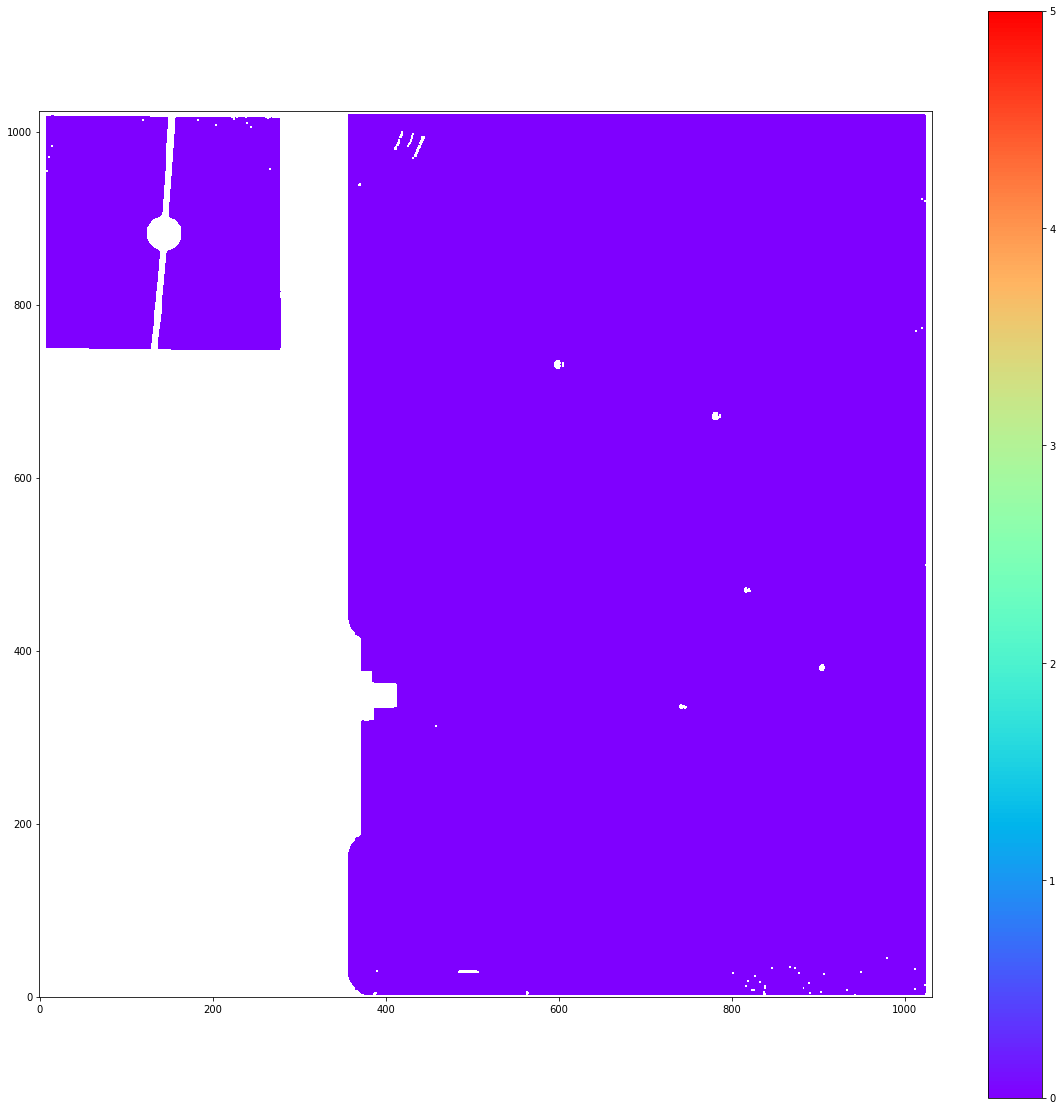

In [31]:
# Look at the dq plane of the flat_field image

plt.figure(figsize=(20,20))

# call out DO_NOT_USE values of 1
masked_flat = np.ma.masked_where((flat_dq & dqflags.pixel['DO_NOT_USE'] > 0), flat_dq)

cmap = matplotlib.cm.get_cmap("rainbow").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

plt.imshow(masked_flat, cmap=cmap, origin='lower', vmin=0,vmax=5)
plt.colorbar()
plt.show()

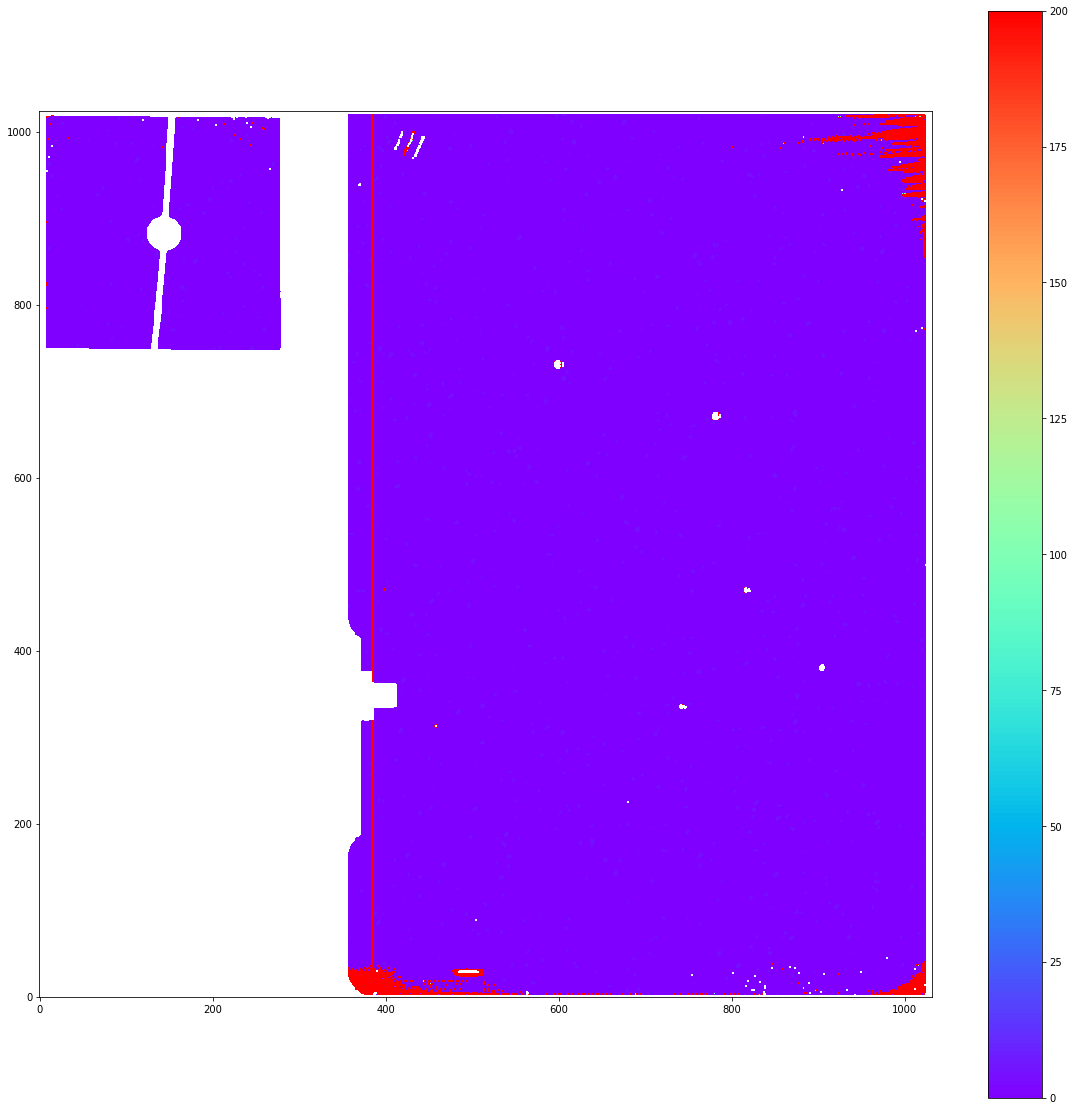

In [32]:
# Look at the dq plane of the cal image

plt.figure(figsize=(20,20))

# call out DO_NOT_USE values of 1
masked_cal = np.ma.masked_where((cal_dq & dqflags.pixel['DO_NOT_USE'] > 0), cal_dq)

cmap = matplotlib.cm.get_cmap("rainbow").copy() # Can be any colormap that you want after the cm
cmap.set_bad(color='white')

plt.imshow(masked_cal, cmap=cmap, origin='lower', vmin=0,vmax=200)
plt.colorbar()
plt.show()

### Take a look at what portion of the flat fielded image will be masked out in combined (image3 pipeline) data

Take the masked NaN region shown above and apply it to the flat fielded image to see what portion of the image will be masked out once calwebb_image3 is run and the DO_NOT_USE pixels are masked out.

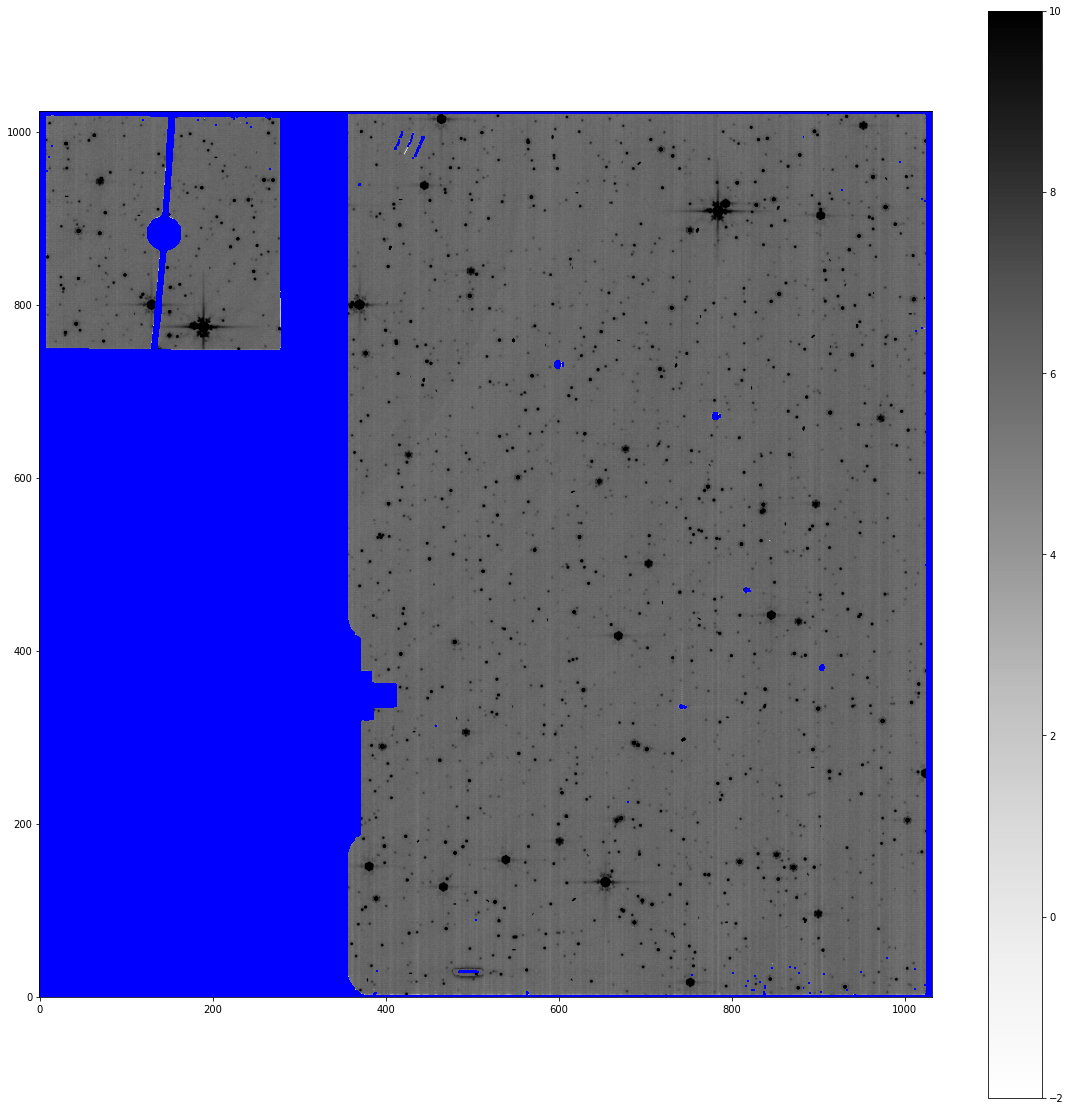

In [33]:
# Look at the dq plane of the cal image

plt.figure(figsize=(20,20))

# call out DO_NOT_USE values of 1
masked_cal = np.ma.masked_where((cal_dq & dqflags.pixel['DO_NOT_USE'] > 0), im_cal.data)

cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='blue')  # Mark the DO_NOT_USE pixel color that will be masked out

plt.imshow(masked_cal, cmap=cmap, origin='lower', vmin=-2,vmax=10)
plt.colorbar()
plt.show()

### Passing criteria

If none of the assert messages or error messages print throughout the notebook and the sci ratio comparison gives values near 1.0, this test passes. The images are mostly for quick checks that nothing looks unusual or out of place.

<a id="about_ID"></a>
## About this Notebook
**Author:** T. Temim and M. Cracraft, INS/MIRI
<br>**Updated On:** 05/11/2021 